<a href="https://colab.research.google.com/github/JSJeong-me/AI-Innovation-2024/blob/main/2-5-Progressive%20GAN%20trained%20on%20CelebA%20for%20128x128%20images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# CelebA Progressive GAN 모델로 인공 얼굴 생성하기


<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf_hub_generative_image_module"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/tf_hub_generative_image_module.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a>
</td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/hub/tutorials/tf_hub_generative_image_module.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a>
</td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/hub/tutorials/tf_hub_generative_image_module.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a>
</td>
  <td><a href="https://tfhub.dev/google/progan-128/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub 모델보기</a></td>
</table>

이 Colab은 GAN(Generative Adversarial Network)을 기반으로 하는 TF-Hub 모듈의 사용 예를 보여줍니다. 이 모듈은 잠재 공간이라고 하는 N-차원 벡터에서 RGB 이미지로 매핑합니다.

두 가지 예가 제공됩니다.

- 잠재 공간에서 이미지로 **매핑**
- 대상 이미지를 고려하여 대상 이미지와 유사한 이미지를 생성하는 잠재 벡터를 **찾기 위해 경사 하강 사용**

## 선택적 전제 조건

- [하위 수준의 Tensorflow 개념](https://www.tensorflow.org/guide/low_level_intro)에 익숙해야 합니다.
- Wikipedia에서 [GAN(Generative Adversarial Network)](https://en.wikipedia.org/wiki/Generative_adversarial_network)을 확인합니다.
- Progressive GAN에 관한 논문을 참조합니다([Progressive Growing of GANs for Improved Quality, Stability, and Variation](https://arxiv.org/abs/1710.10196)).

### 더 많은 모델

[여기](https://tfhub.dev/s?module-type=image-generator)에서 [tfhub.dev](https://tfhub.dev/)에서 현재 호스팅되며 이미지를 생성할 수 있는 모든 모델을 확인할 수 있습니다.

## 설정

In [2]:
# Install imageio for creating animations.
!pip -q install imageio
!pip -q install scikit-image
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ad0j6d79
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ad0j6d79
  Resolved https://github.com/tensorflow/docs to commit 27ba8a4db8b73311e525d1e0e833877111b3d1e6
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2024.7.15.51478-py3-none-any.whl size=182586 sha256=962472e6d1cf3c845121b72d5e14f21d5c470d754bcf743a63818e64c2f49433
  Stored in directory: /tmp/pip-ephem-wheel-cache-t9xu5sfh/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [3]:
#@title Imports and function definitions
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512


# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1.
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

## 잠재 공간 보간

### 무작위 벡터

무작위로 초기화된 두 벡터 사이의 잠재 공간을 보간합니다. 사전 훈련된 Progressive GAN이 포함된 TF-Hub 모듈 [progan-128](https://tfhub.dev/google/progan-128/1)을 사용합니다.

In [14]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']


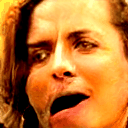

In [15]:
def interpolate_between_vectors():
  v1 = tf.random.normal([latent_dim])
  v2 = tf.random.normal([latent_dim])

  # Creates a tensor with 25 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

## 잠재 공간에서 가장 가까운 벡터 찾기

대상 이미지를 수정합니다. 예를 들어, 모듈에서 생성된 이미지를 사용하거나 고유한 이미지를 업로드합니다.

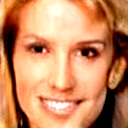

In [16]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()

display_image(target_image)

대상 이미지와 잠재 공간 변수에 의해 생성된 이미지 사이의 손실 함수를 정의한 후, 경사 하강을 사용하여 손실을 최소화하는 변수 값을 찾을 수 있습니다.

In [7]:
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])

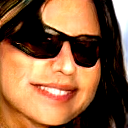

In [8]:
display_image(progan(initial_vector)['default'][0])

In [17]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      target_image_difference = loss_fn(image, target_image[:,:,:3])
      # The latent vectors were sampled from a normal distribution. We can get
      # more realistic images if we regularize the length of the latent vector to
      # the average length of vector from this distribution.
      regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))

  return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

(0.0, 5135.745065307618)

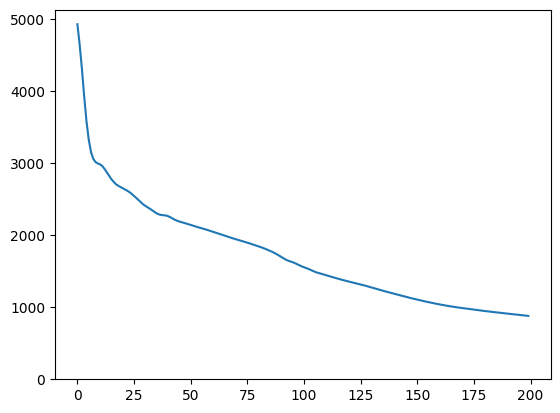

In [18]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])


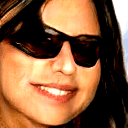

In [19]:
animate(np.stack(images))

결과를 대상과 비교합니다.

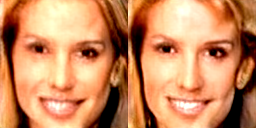

In [20]:
display_image(np.concatenate([images[-1], target_image], axis=1))

### 위의 예를 이용한 추가 작업

이미지가 모듈 공간의 이미지인 경우, 하강이 빠르고 합리적인 샘플로 수렴합니다. **모듈 공간의 이미지가 아닌** 이미지로 하강해 보세요. 이미지가 훈련 이미지 공간에 상당히 가까운 경우에만 하강이 수렴합니다.

하강이 더 빠르고 더 현실적인 이미지를 만드는 방법은? 다음을 시도해볼 수 있습니다.

- 이미지 차이에 대해 다른 손실을 사용합니다(예: 2차 방정식).
- 잠재 벡터에 다른 regularizer를 사용합니다.
- 여러 번의 실행 후에 무작위 벡터에서 초기화합니다.
- 기타
